In [ ]:
# Input Rainfall Data
import xarray as xr
precip = xr.open_dataset("/content/GroupH.nc")
precip

<xarray.Dataset> Size: 4MB
Dimensions:    (TIME: 8540, LATITUDE: 12, LONGITUDE: 5)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 40B 72.5 73.5 74.5 75.5 76.5
  * LATITUDE   (LATITUDE) float64 96B 8.5 9.5 10.5 11.5 ... 16.5 17.5 18.5 19.5
  * TIME       (TIME) datetime64[ns] 68kB 1951-03-01 1951-03-02 ... 2020-06-30
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 4MB ...
Attributes:
    history:      FERRET V7.5 (optimized) 28-Mar-22
    Conventions:  CF-1.6

In [ ]:
# -*- coding: utf-8 -*-
# Data Preprocessing
import numpy as np

EARTH_RADIUS = 6371000.0  # m


def _guess_bounds(points, bound_position=0.5):

    diffs = np.diff(points)
    diffs = np.insert(diffs, 0, diffs[0])
    diffs = np.append(diffs, diffs[-1])

    min_bounds = points - diffs[:-1] * bound_position
    max_bounds = points + diffs[1:] * (1 - bound_position)

    return np.array([min_bounds, max_bounds]).transpose()


def _quadrant_area(radian_lat_bounds, radian_lon_bounds, radius_of_earth):

    # ensure pairs of bounds
    if (
        radian_lat_bounds.shape[-1] != 2
        or radian_lon_bounds.shape[-1] != 2
        or radian_lat_bounds.ndim != 2
        or radian_lon_bounds.ndim != 2
    ):
        raise ValueError("Bounds must be [n,2] array")

    # fill in a new array of areas
    radius_sqr = radius_of_earth ** 2
    radian_lat_64 = radian_lat_bounds.astype(np.float64)
    radian_lon_64 = radian_lon_bounds.astype(np.float64)

    ylen = np.sin(radian_lat_64[:, 1]) - np.sin(radian_lat_64[:, 0])
    xlen = radian_lon_64[:, 1] - radian_lon_64[:, 0]
    areas = radius_sqr * np.outer(ylen, xlen)

    # we use abs because backwards bounds (min > max) give negative areas.
    return np.abs(areas)


def grid_cell_areas(lon1d, lat1d, radius=EARTH_RADIUS):

    lon_bounds_radian = np.deg2rad(_guess_bounds(lon1d))
    lat_bounds_radian = np.deg2rad(_guess_bounds(lat1d))
    area = _quadrant_area(lat_bounds_radian, lon_bounds_radian, radius)
    return area


def calc_spatial_mean(
    xr_da, lon_name="LONGITUDE", lat_name="LATITUDE",radius=EARTH_RADIUS
):

    lon = xr_da[lon_name].values
    lat = xr_da[lat_name].values

    area_weights = grid_cell_areas(lon, lat, radius=radius)
    aw_factor = area_weights / area_weights.max()

    return (xr_da * aw_factor).mean(dim=[lon_name, lat_name])


def calc_spatial_integral(
    xr_da, lon_name="LONGITUDE", lat_name="LATITUDE", radius=EARTH_RADIUS
):

    lon = xr_da[lon_name].values
    lat = xr_da[lat_name].values

    area_weights = grid_cell_areas(lon, lat, radius=radius)

    return (xr_da * area_weights).sum(dim=[lon_name, lat_name])

In [ ]:
Spatial_mean_precip = calc_spatial_mean(precip)
Spatial_mean_precip

<xarray.Dataset> Size: 137kB
Dimensions:   (TIME: 8540)
Coordinates:
  * TIME      (TIME) datetime64[ns] 68kB 1951-03-01 1951-03-02 ... 2020-06-30
Data variables:
    RAINFALL  (TIME) float64 68kB 0.0 0.0 0.0 0.0 ... 12.13 8.307 7.244 14.77

In [ ]:
Yearly_max_array = Spatial_mean_precip['RAINFALL'].groupby("TIME.year").max("TIME")
Yearly_max_array

<xarray.DataArray 'RAINFALL' (year: 70)> Size: 560B
array([30.69016444, 27.4888773 , 36.95200966, 35.17414225, 37.42678764,
       49.3426889 , 26.19766935, 43.61547357, 45.43678674, 30.59128732,
       50.78961711, 21.454163  , 24.26840626, 19.82347632, 27.77771518,
       34.92593942, 33.17239362, 26.08171237, 20.21270244, 32.22066143,
       37.06650512, 37.63675227, 28.78455304, 14.45333657, 42.18885692,
       22.3947587 , 30.643617  , 40.63031617, 40.56446827, 36.70802654,
       34.02992233, 30.43783207, 30.23325393, 32.85329276, 38.53079925,
       30.43172223, 22.41720585, 23.33197515, 25.61297773, 25.06946593,
       66.6871107 , 37.78079303, 33.41114222, 41.83827029, 31.32888339,
       50.61424777, 50.15506869, 39.5545262 , 50.26656246, 29.00159945,
       30.98035931, 31.89380904, 38.57818025, 28.50091689, 40.42212131,
       35.76569162, 68.59175271, 35.96070512, 34.59916082, 11.35720483,
       30.8065249 , 47.88282733, 30.81549105, 31.70065561, 36.2966785 ,
       33.2943517 , 29.98946224, 35.52008129, 29.83679738, 23.97872711])
Coordinates:
  * year     (year) int64 560B 1951 1952 1953 1954 1955 ... 2017 2018 2019 2020

In [ ]:
yearly_max_array_1961_1990 = Yearly_max_array.sel(year=slice('1961','1990'))
yearly_max_array_1961_1990

<xarray.DataArray 'RAINFALL' (year: 30)> Size: 240B
array([50.78961711, 21.454163  , 24.26840626, 19.82347632, 27.77771518,
       34.92593942, 33.17239362, 26.08171237, 20.21270244, 32.22066143,
       37.06650512, 37.63675227, 28.78455304, 14.45333657, 42.18885692,
       22.3947587 , 30.643617  , 40.63031617, 40.56446827, 36.70802654,
       34.02992233, 30.43783207, 30.23325393, 32.85329276, 38.53079925,
       30.43172223, 22.41720585, 23.33197515, 25.61297773, 25.06946593])
Coordinates:
  * year     (year) int64 240B 1961 1962 1963 1964 1965 ... 1987 1988 1989 1990

In [ ]:

Yearly_max_array

<xarray.DataArray 'RAINFALL' (year: 70)> Size: 560B
array([30.69016444, 27.4888773 , 36.95200966, 35.17414225, 37.42678764,
       49.3426889 , 26.19766935, 43.61547357, 45.43678674, 30.59128732,
       50.78961711, 21.454163  , 24.26840626, 19.82347632, 27.77771518,
       34.92593942, 33.17239362, 26.08171237, 20.21270244, 32.22066143,
       37.06650512, 37.63675227, 28.78455304, 14.45333657, 42.18885692,
       22.3947587 , 30.643617  , 40.63031617, 40.56446827, 36.70802654,
       34.02992233, 30.43783207, 30.23325393, 32.85329276, 38.53079925,
       30.43172223, 22.41720585, 23.33197515, 25.61297773, 25.06946593,
       66.6871107 , 37.78079303, 33.41114222, 41.83827029, 31.32888339,
       50.61424777, 50.15506869, 39.5545262 , 50.26656246, 29.00159945,
       30.98035931, 31.89380904, 38.57818025, 28.50091689, 40.42212131,
       35.76569162, 68.59175271, 35.96070512, 34.59916082, 11.35720483,
       30.8065249 , 47.88282733, 30.81549105, 31.70065561, 36.2966785 ,
       33.2943517 , 29.98946224, 35.52008129, 29.83679738, 23.97872711])
Coordinates:
  * year     (year) int64 560B 1951 1952 1953 1954 1955 ... 2017 2018 2019 2020

In [ ]:
precip_95 = np.percentile(yearly_max_array_1961_1990,95)
precip_95

41.48751358489897

In [ ]:
precip_99 = np.percentile(yearly_max_array_1961_1990,99)
precip_99

48.295396653431396

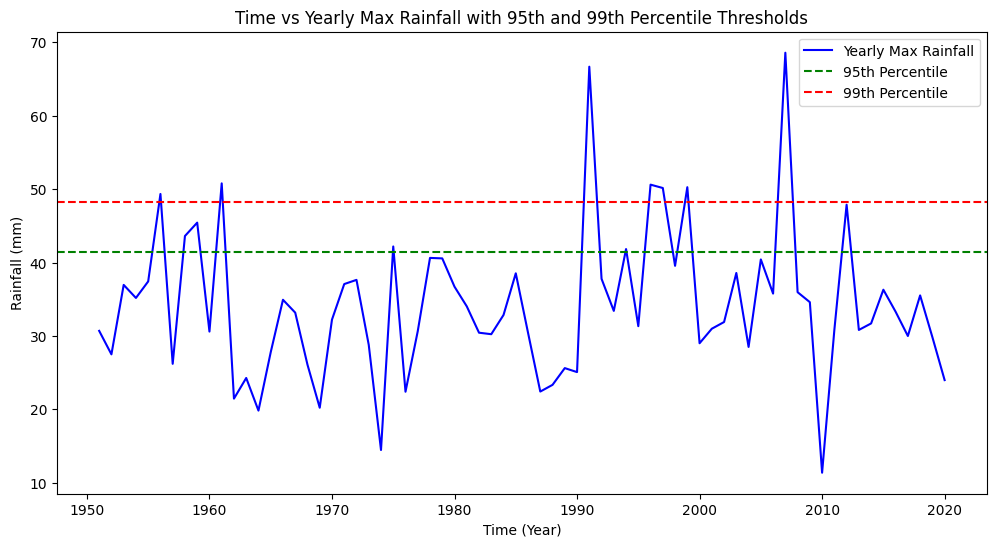

In [ ]:
# Extract only the year values
time_values = Spatial_mean_precip['TIME'].dt.year.groupby("TIME.year").first().values

# Extract the maximum rainfall values per year
rainfall_values = Spatial_mean_precip['RAINFALL'].groupby("TIME.year").max("TIME").values


# Plotting
plt.figure(figsize=(12, 6))

# Plot time vs rainfall
plt.plot(time_values, rainfall_values, label='Yearly Max Rainfall', color='blue')

# Plot the 95th percentile threshold
plt.axhline(y=precip_95, color='green', linestyle='--', label='95th Percentile')

# Plot the 99th percentile threshold
plt.axhline(y=precip_99, color='red', linestyle='--', label='99th Percentile')

# Adding titles and labels
plt.title("Time vs Yearly Max Rainfall with 95th and 99th Percentile Thresholds")
plt.xlabel("Time (Year)")
plt.ylabel("Rainfall (mm)")

# Display legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def ecdf(data):

    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y



# Calculate ECDF
x, y = ecdf(Yearly_max_array)

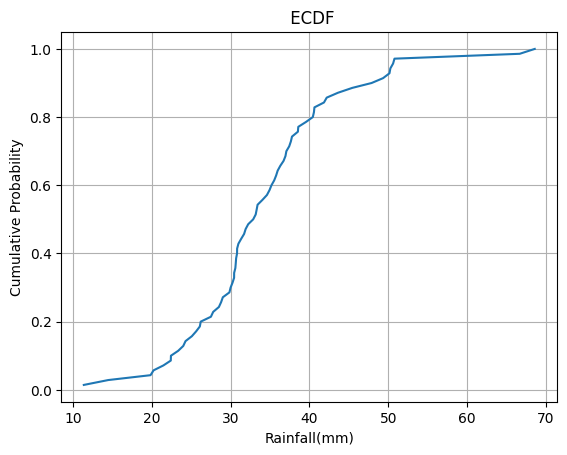

In [ ]:
# Plot the CDF
plt.plot(x, y)
plt.xlabel('Rainfall(mm)')
plt.ylabel('Cumulative Probability')
plt.title(' ECDF')
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import pearson3
shape, loc, scale = pearson3.fit(Yearly_max_array)
# range of values
d = np.sort(Yearly_max_array)
value = d

# Calculate the PDF of the distribution
cdf_pearson3 = pearson3.cdf(value, shape, loc, scale)

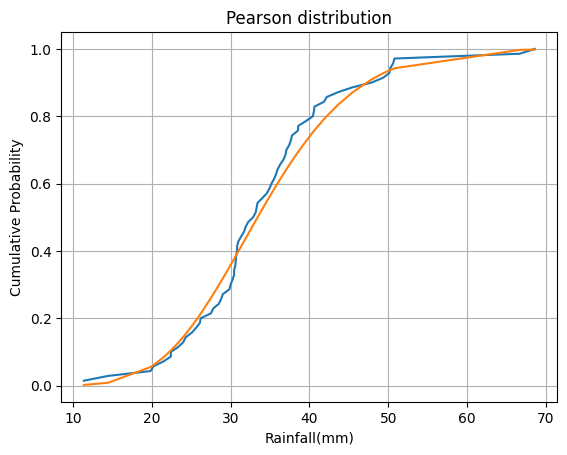

In [ ]:
plt.plot(x, y)
plt.plot(x, cdf_pearson3)
plt.xlabel('Rainfall(mm)')
plt.ylabel('Cumulative Probability')
plt.title('Pearson distribution')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y, cdf_pearson3 ))
rms

0.038412966482833336

In [ ]:
from scipy.stats import lognorm

shape, loc, scale = lognorm.fit(Yearly_max_array)
# range of values
d = np.sort(Yearly_max_array)
value = d

# Calculate the PDF of the distribution
cdf_lognorm = lognorm.cdf(value, shape, loc, scale)

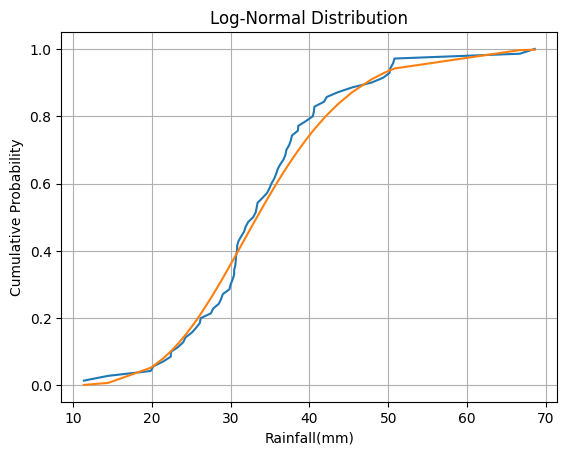

In [ ]:
plt.plot(x, y)
plt.plot(x, cdf_lognorm)
plt.xlabel('Rainfall(mm)')
plt.ylabel('Cumulative Probability')
plt.title('Log-Normal Distribution')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y, cdf_lognorm ))
rmse

0.036560834693616644

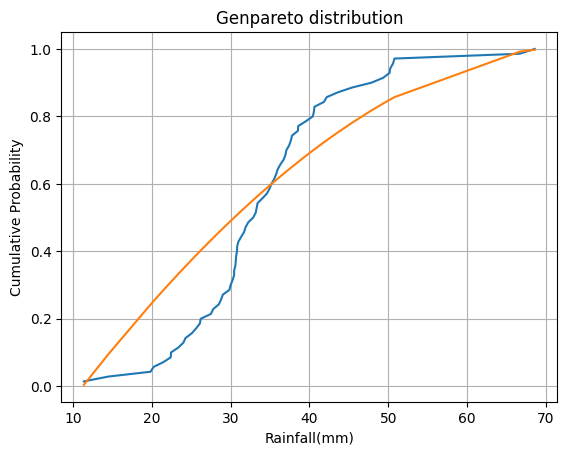

0.13297089318120556

In [ ]:
from scipy.stats import genpareto

# Fit a Generalized Pareto Distribution to the data
shape, loc, scale = genpareto.fit(Yearly_max_array)

# Calculate the CDF of the fitted Generalized Pareto Distribution
x = np.sort(Yearly_max_array)
cdf_genpareto = genpareto.cdf(x, shape, loc, scale)

plt.plot(x, y)
plt.plot(x, cdf_genpareto)
plt.xlabel('Rainfall(mm)')
plt.ylabel('Cumulative Probability')
plt.title('Genpareto distribution')
plt.grid(True)
plt.show()

rmse = sqrt(mean_squared_error(y, cdf_genpareto ))
rmse

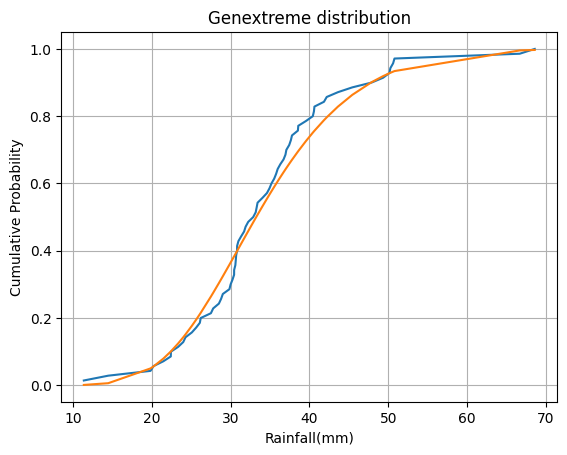

0.03835389189103863

In [ ]:
from scipy.stats import genextreme

shape, loc, scale = genextreme.fit(Yearly_max_array)
# range of values
value = np.sort(Yearly_max_array)

# Calculate the PDF of the distribution
cdf_genextreme = genextreme.cdf(value, shape, loc, scale)

plt.plot(x, y)
plt.plot(x, cdf_genextreme)
plt.xlabel('Rainfall(mm)')
plt.ylabel('Cumulative Probability')
plt.title('Genextreme distribution')
plt.grid(True)
plt.show()


rms = sqrt(mean_squared_error(y, cdf_genextreme ))
rms

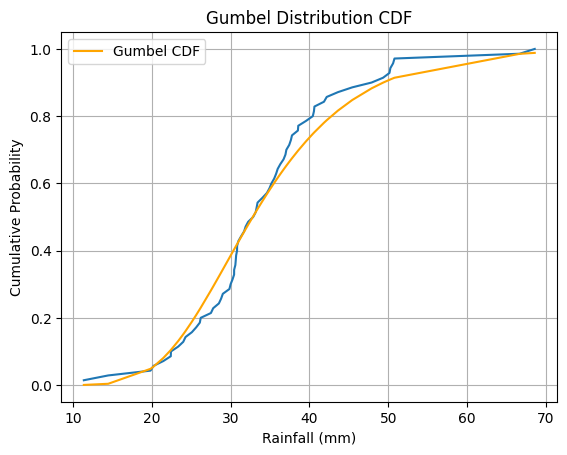

0.04392743976911321

In [ ]:
from scipy.stats import gumbel_r
from sklearn.metrics import mean_squared_error


# Fit a Gumbel distribution to the data
loc, scale = gumbel_r.fit(Yearly_max_array)

# Range of values (sorted)
value = np.sort(Yearly_max_array)

# Calculate the CDF of the fitted Gumbel distribution
cdf_gumbel = gumbel_r.cdf(value, loc=loc, scale=scale)

# Plot the empirical CDF vs the fitted Gumbel CDF
plt.plot(x,y)
plt.plot(value, cdf_gumbel, label='Gumbel CDF', color='orange')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Cumulative Probability')
plt.title('Gumbel Distribution CDF')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the RMSE between empirical and Gumbel CDF
rmse = sqrt(mean_squared_error(y, cdf_gumbel ))
rmse


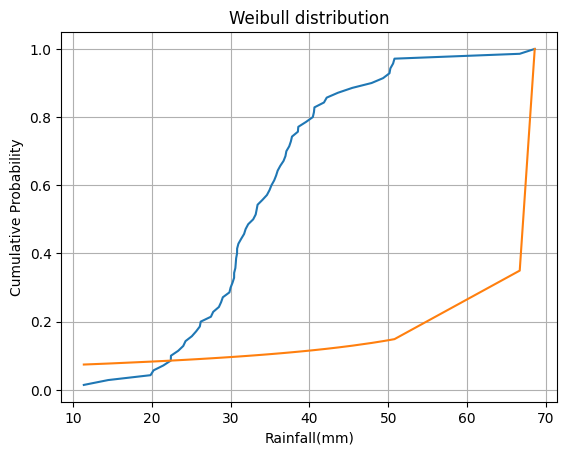

0.4700226893120446

In [ ]:
from scipy.stats import weibull_max

shape, loc, scale = weibull_max.fit(Yearly_max_array)
# range of values
value = np.sort(Yearly_max_array)

# Calculate the PDF of the distribution
cdf_weibull_max = weibull_max.cdf(value, shape, loc, scale)

plt.plot(x, y)
plt.plot(x, cdf_weibull_max)
plt.xlabel('Rainfall(mm)')
plt.ylabel('Cumulative Probability')
plt.title('Weibull distribution')
plt.grid(True)
plt.show()

rms = sqrt(mean_squared_error(y, cdf_weibull_max ))
rms

In [ ]:
#Log Normal Distribution has lowest RMSE, hence it is selected as best fit distribution

In [ ]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt
# Fit the generalized extreme value distribution to the data.
shape, loc, scale = lognorm.fit(Yearly_max_array)
print("Fit parameters:")
print(f"  shape: {shape:.4f}")
print(f"  loc:   {loc:.4f}")
print(f"  scale: {scale:.4f}")
print()

Fit parameters:
  shape: 0.1814
  loc:   -19.6434
  scale: 52.9734



In [ ]:
# Calculate the PDF of the distribution
cdf_95 = lognorm.cdf(precip_95, shape, loc, scale)
cdf_95

0.785102223922461

In [ ]:
Exceedance_prob_95  = 1 - cdf_95
Exceedance_prob_95

0.21489777607753902

In [ ]:
cdf_99 = lognorm.cdf(precip_99, shape, loc, scale)
cdf_99

0.9149062942754345

In [ ]:
Exceedance_prob_99  = 1 - cdf_99
Exceedance_prob_99

0.08509370572456554